In [1]:
from CASBI.utils.create_dataframe import rescale 
from CASBI.generator.fff.fff_model import FreeFormFlow

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde

import torch

In [3]:
data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
data =  data.drop(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)

# data = rescale(df=data, mean_and_std_path='../../data/preprocess', inverse=True, save=False, scale_observations=True)

# mean_and_std_df = pd.read_parquet('../../MW_MH/data/preprocessing_subsample/mean_and_std_preprocessing.parquet')
# data = utils.rescale(data, mean_and_std_path='../../MW_MH/data/preprocessing_subsample/mean_and_std_preprocessing.parquet', inverse=True)
print('Number of Galaxy: ',len(data['Galaxy_name'].unique()))

Number of Galaxy:  4401


In [15]:
sample_halo_name = data['Galaxy_name'].sample(2)
sample_halo = data[data['Galaxy_name'].isin(sample_halo_name)]
sample_halo

,feh,ofe,star_log10mass,gas_log10mass,dm_log10mass,infall_time,mean_metallicity,std_metallicity,Galaxy_name
1036571,1.363899,0.540207,1.500119,1.236272,1.30019,0.171056,2.038971,1.576702,g3.06e11.00576
1036572,0.863337,0.979785,1.500119,1.236272,1.30019,0.171056,2.038971,1.576702,g3.06e11.00576
1036573,1.507471,0.325611,1.500119,1.236272,1.30019,0.171056,2.038971,1.576702,g3.06e11.00576
1036574,1.534065,0.479366,1.500119,1.236272,1.30019,0.171056,2.038971,1.576702,g3.06e11.00576
1036575,1.410293,0.264212,1.500119,1.236272,1.30019,0.171056,2.038971,1.576702,g3.06e11.00576
...,...,...,...,...,...,...,...,...,...
1960635,-0.035973,-1.677537,-1.458205,-1.018359,-1.14255,-0.919786,-0.598932,-0.544486,g7.05e09.00272
1960636,-0.995380,0.035047,-1.458205,-1.018359,-1.14255,-0.919786,-0.598932,-0.544486,g7.05e09.00272
1960637,0.005162,-0.683256,-1.458205,-1.018359,-1.14255,-0.919786,-0.598932,-0.544486,g7.05e09.00272
1960638,-0.561692,-0.755296,-1.458205,-1.018359,-1.14255,-0.919786,-0.598932,-0.544486,g7.05e09.00272


In [16]:
def plot_halo(df_halo:pd.DataFrame, data:pd.DataFrame):
    """
    Plots the halo data.

    Args:
        df_halo (pd.DataFrame): The halo data containing galaxy names, [Fe/H], and [O/Fe].
        data (pd.DataFrame): The data set from which [Fe/H] and [O/Fe] ranges are extracted to set the boundaries of the plots and the returned histogram

    Returns:
        tuple: A tuple containing the histogram, x-edges, and y-edges.
    """
    min_feh, max_feh = min(data['feh']), max(data['feh'])
    min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(121)
    for name in df_halo['Galaxy_name'].unique():
        ax.scatter(df_halo[df_halo['Galaxy_name']==name]['feh'], df_halo[df_halo['Galaxy_name']==name]['ofe'], label=name, s=2)
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[O/Fe]')
    ax.set_xlim((min_feh, max_feh))
    ax.set_ylim((min_ofe, max_ofe))
    ax.legend(bbox_to_anchor=(-0.60, 1), loc='upper left')
        
    ax = fig.add_subplot(122)
    feh_ofe = df_halo[['feh', 'ofe']].values
    num_bins=100
    #with density=True the integral is equal to one, so also the support needs to be multiply
    hist, xedges, yedges = np.histogram2d(feh_ofe[:,0], feh_ofe[:,1], bins=num_bins, range=[[min_feh, max_feh], [min_ofe, max_ofe]], density=True)
    # hist, xedges, yedges, im = ax.hist2d(x=fake_halo['feh'], y=fake_halo['ofe'], bins=50, cmap='magma');
    im = ax.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='viridis')
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[O/Fe]')
    fig.colorbar(im, ax=ax, label='Counts')
    return hist, xedges, yedges

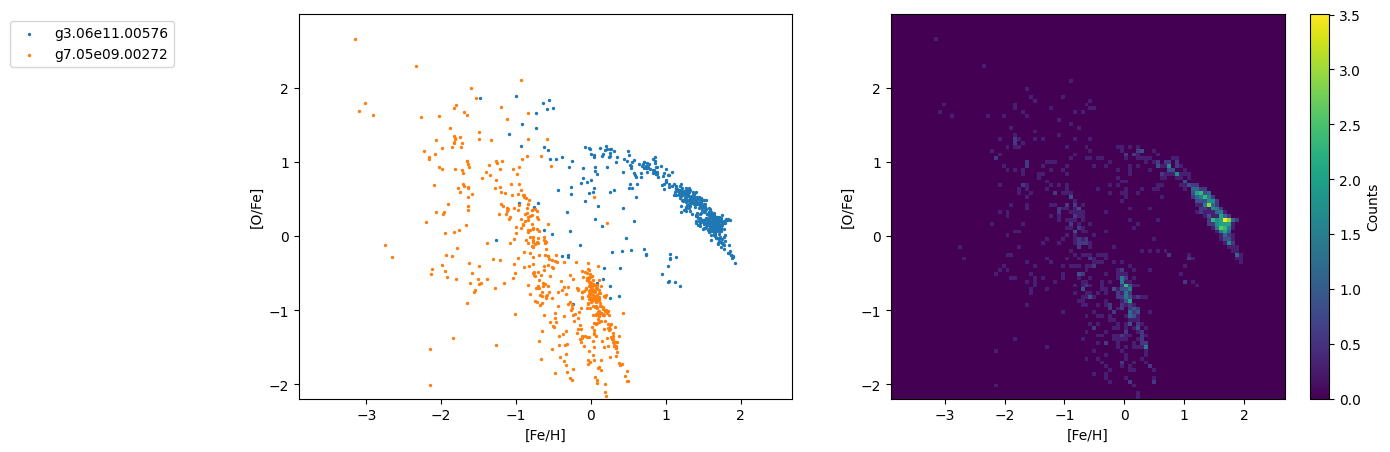

In [20]:
hist, xdges, yedges = plot_halo(df_halo=sample_halo, data=data)

Text(0.5, 0, 'Counts')

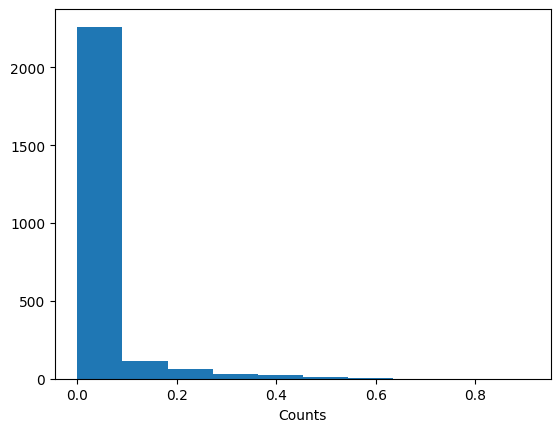

In [9]:
plt.hist(hist.reshape(50**2));
plt.xlabel('Counts')

In [10]:
def gen_conditions(conditions, n_bins=100, halo_number=int):
    """Generate sample conditions based on given conditions, taking into account correlations between conditions.

    Args:
        conditions (pandas.DataFrame): The conditions to generate sample conditions from.
        n_bins (int, optional): The number of bins to use for generating sample conditions. Defaults to 100.

    Returns:
        dict: The generated sample conditions.

    """
    
    bin_mass = (max(conditions['star_log10mass'].values) - min(conditions['star_log10mass'].values))/n_bins
    kde = gaussian_kde(conditions['star_log10mass'])
    star_mass = kde.resample(1)[0][0]
    sample_conditions = {'star_log10mass': star_mass}
    
    cut_in_mass = conditions[(star_mass - bin_mass < conditions['star_log10mass']) & (conditions['star_log10mass']<star_mass + bin_mass)]
    conditions_to_sample = cut_in_mass.columns.difference(['star_log10mass', 'infall_time', 'Galaxy_name'], sort=False)
   
    for i, col in enumerate(conditions_to_sample):
        possible_cond = cut_in_mass[col].values
        kde = gaussian_kde(possible_cond)
        sample_conditions[col] = kde.resample(1)[0][0]

    kde = gaussian_kde(conditions['infall_time'])
    infall_time = kde.resample(1)[0][0]
    sample_conditions['infall_time'] = infall_time
    sample_conditions['Galaxy_name'] = f'Generated_galaxy:{halo_number}'
    
    return sample_conditions 


def gen_halo_conditions(n_halos:int, conditions:pd.DataFrame, n_bins:int=100):
    genereated_halo_conditions = pd.DataFrame(columns = conditions.columns)
    
    for n in range(n_halos):
        sample_conditions = gen_conditions(conditions, n_bins=n_bins, halo_number=n)
        genereated_halo_conditions.loc[len(genereated_halo_conditions)] = sample_conditions
    genereated_halo_conditions = genereated_halo_conditions.reindex(columns=conditions.columns)
    return genereated_halo_conditions

In [14]:
conditions = data[data.columns.difference(['feh', 'ofe'], sort=False)]
generated_halo_conditions = gen_halo_conditions(n_halos=2, conditions=conditions, n_bins=10)
generated_halo_conditions

,star_log10mass,gas_log10mass,dm_log10mass,infall_time,mean_metallicity,std_metallicity,Galaxy_name
0,-1.347495,-0.896022,-1.404851,-1.562717,-0.527349,-0.503081,Generated_galaxy:0
1,0.897207,0.862688,0.735264,0.392743,0.907025,1.106679,Generated_galaxy:1


In [15]:
model_snapshot = './snapshot/fff_snapshot/snapshot.pth'
Flow = FreeFormFlow(dim = 2, 
                    cond_dim = 6,
                    hidden_dim = 128,
                    latent_dim = 2,
                    n_SC_layer = 6,
                    beta = 100**2,
                    device = 'cuda')

Flow.load_state_dict(torch.load(model_snapshot))


<All keys matched successfully>

In [16]:
def gen_halo(halo_conditions, generator):
    """  
    Generate a halo based on given conditions.
    """

    for i in range(len(halo_conditions)):
        cond = torch.tensor(halo_conditions.iloc[i, :-1].values.astype(float)).float().to('cuda')
        cond = cond.repeat(500, 1)
        halo = generator.sample(500, cond).cpu().detach().numpy()
        if i==0:
            df_halo = pd.DataFrame(halo, columns=['feh', 'ofe'])
            for col in halo_conditions.columns:
                df_halo[col] = halo_conditions[col].iloc[i]
        else:
            halo = pd.DataFrame(halo, columns=['feh', 'ofe'])
            for col in halo_conditions.columns:
                halo[col] = halo_conditions[col].iloc[i]
            df_halo = pd.concat([df_halo, halo]) 
    return df_halo

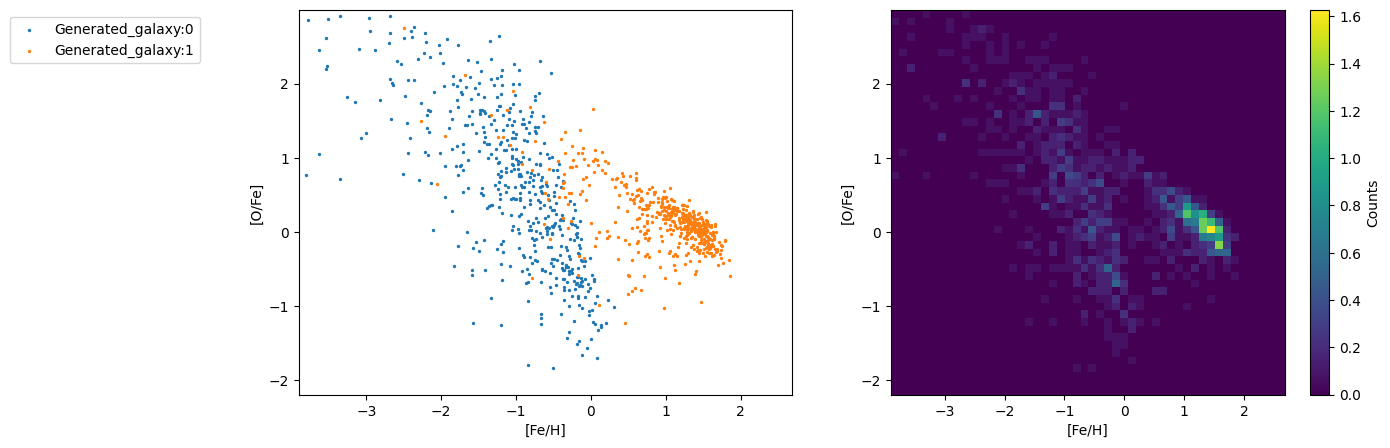

In [17]:
df_halo = gen_halo(generated_halo_conditions, Flow)
plot_halo(df_halo=df_halo, data=data);

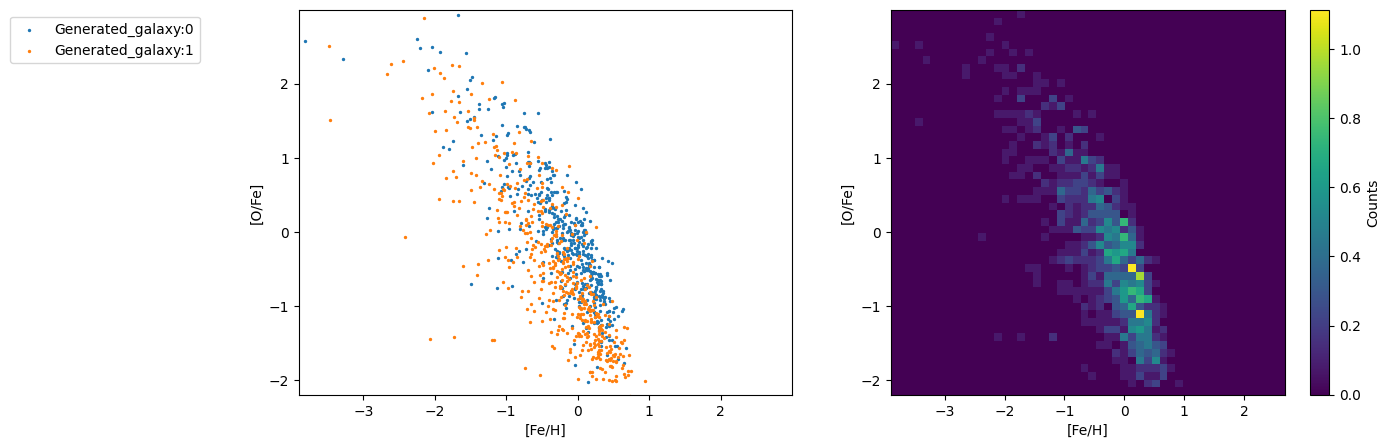

In [46]:
conditions = data[data.columns.difference(['feh', 'ofe'], sort=False)]
generated_halo_conditions = gen_halo_conditions(n_halos=2, conditions=conditions, n_bins=10)
df_halo = gen_halo(generated_halo_conditions, Flow)
plot_halo(df_halo=df_halo, data=data);